In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
%matplotlib inline

# Multi-Armed Bandits

### References

1. [ Reinforcement Learning: An Introduction Richard S. Sutton and Andrew G. Barto](http://incompleteideas.net/book/RLbook2018.pdf)
2. https://github.com/ShangtongZhang/reinforcement-learning-an-introduction

You are faced repeatedly with a choice among $k$ different options, or actions. After each choice you receive a numerical reward chosen from a stationary probability distribution that depends on the action you selected. Your objective is to maximize the expected total reward over some time period, for example, over 1000 action selections, or time steps.

In this test bed, the true value $q_*(a)$ of each of the ten actions was selected according to a normal distribution with mean zero and unit variance, and then the actual rewards were selected according to a mean $q_*(a)$ and $\sigma=0.2$ normal distribution.

In [2]:
def visualize_mab_distribution(n_actions=10,n_samples=200):
    q_star = np.random.randn(n_actions)
    dataset = q_star + (0.2 * np.random.randn(n_samples, n_actions))
    plt.figure(figsize=(15, 8))
    plt.violinplot(dataset=dataset,showmeans=True)
    plt.xlabel("Action")
    plt.ylabel("Reward distribution")
    plt.show()
    return dataset

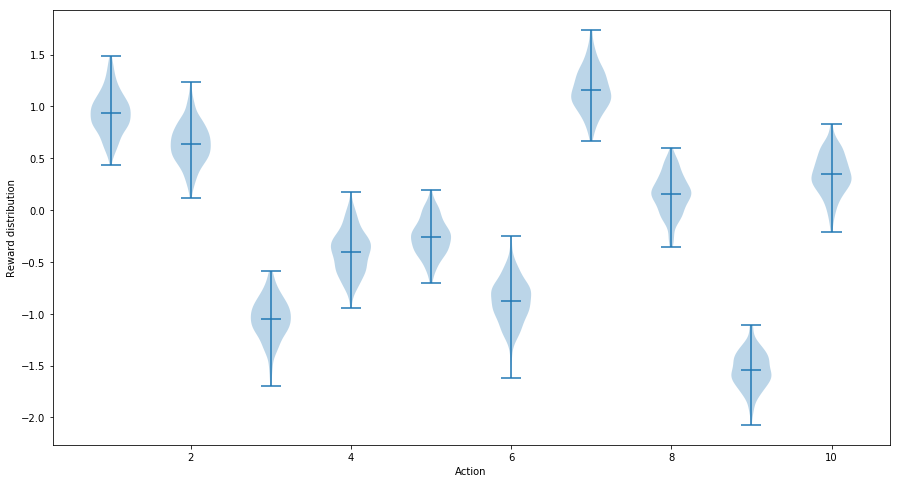

In [3]:
ds = visualize_mab_distribution()

In [21]:
from abc import ABC,abstractmethod

class Bandit(ABC):
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    def __init__(self, k_arm=10, epsilon=0.):
        self.k = k_arm
        self.indices = np.arange(self.k)
        self.time = 0
        self.average_reward = 0
        self.epsilon = epsilon
    
    def __repr__(self):
        return "{}-eps:{:.3f}".format(self.__class__.__name__,self.epsilon)

    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k)
        
        # estimation for each action
        self.q_estimation = np.zeros(self.k) 

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

        self.time = 0
    
    @abstractmethod
    def pick_best_action(self):
        pass        

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)
        else:
            return self.pick_best_action()
    
    @abstractmethod
    def update_estimate(self,reward):
        # update q_estimation based on the reward
        pass        
      

    # take an action, update estimation for this action
    def step(self, action):
        reward =  (0.2 * np.random.randn()) + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time
        self.update_estimate(action,reward)
        return reward
    
    
def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

def visualize_average_performance(bandit_clz=None, runs=50, time=2000):
    
    epsilons = [0, 0.1, 0.01]
    bandits = [bandit_clz(epsilon=eps) for eps in epsilons]
    title = bandit_clz.__name__
    best_action_counts, rewards = simulate(runs, time, bandits)

    plt.figure(figsize=(20, 10))

    plt.subplot(2, 1, 1)
    for eps, rewards in zip(epsilons, rewards):
        plt.plot(rewards, label='epsilon = %.02f' % (eps))
    plt.xlabel('steps')
    plt.ylabel('average reward')
    plt.title(bandit_clz.__name__)
    plt.legend()

    plt.subplot(2, 1, 2)
    for eps, counts in zip(epsilons, best_action_counts):
        plt.plot(counts, label='epsilon = %.02f' % (eps))
    plt.xlabel('steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.show()


def visualize_bandits_avg_performance(bandits, runs=50, time=2000):
    best_action_counts, rewards = simulate(runs, time, bandits)
    plt.figure(figsize=(20, 15))

    plt.subplot(2, 1, 1)
    for bandit, rewards in zip(bandits, rewards):
        plt.plot(rewards, label=bandit)
    plt.xlabel('steps')
    plt.ylabel('average reward')
    plt.legend()

    plt.subplot(2, 1, 2)
    for bandit, counts in zip(bandits, best_action_counts):
        plt.plot(counts, label=bandit)
    plt.xlabel('steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.show()

# Simple Averaging
![simple averaging](./simple_averaging.png)

In [5]:
class SampleAveragingBandit(Bandit):
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    def __init__(self, k_arm=10, epsilon=0.):
        super(SampleAveragingBandit,self).__init__(k_arm,epsilon)
        self.action_rewards = {k:[] for k in range(self.k)}
    def reset(self):
        super().reset()
        self.action_rewards = {k:[] for k in range(self.k)}
    def pick_best_action(self):
        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])
    def update_estimate(self,action,reward):
        """
        Implement this method
        compute the action value using the above equation
        """
        self.action_rewards[action].append(reward)
        q_action_estimate = np.mean(self.action_rewards[action])
        self.q_estimation[action] = q_action_estimate       

100%|██████████| 50/50 [00:08<00:00,  5.69it/s]


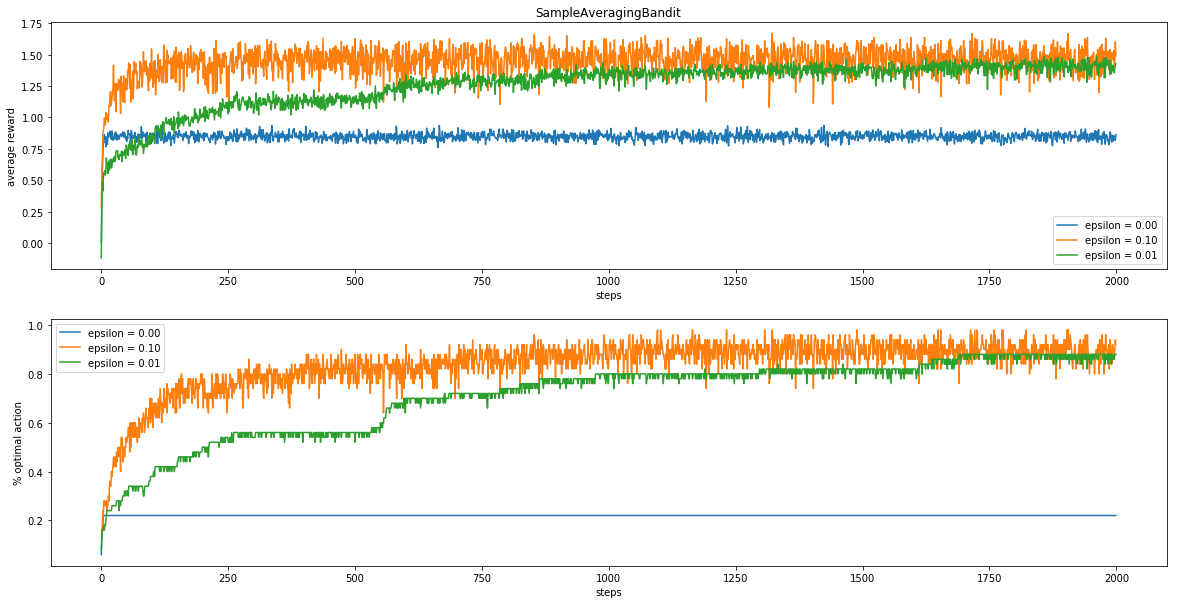

In [6]:
visualize_average_performance(SampleAveragingBandit)

# Incremental Averaging

![ba](./bandit_algo.png)

In [7]:
class SampleAveragingIncementalBandit(Bandit):
    def pick_best_action(self):
        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])
    def update_estimate(self,action,reward):
        """
        Implement this method using the update rule in the above algorithm
        """
        self.q_estimation[action]  += (reward-self.q_estimation[action])/self.action_count[action]

100%|██████████| 50/50 [00:02<00:00, 20.58it/s]


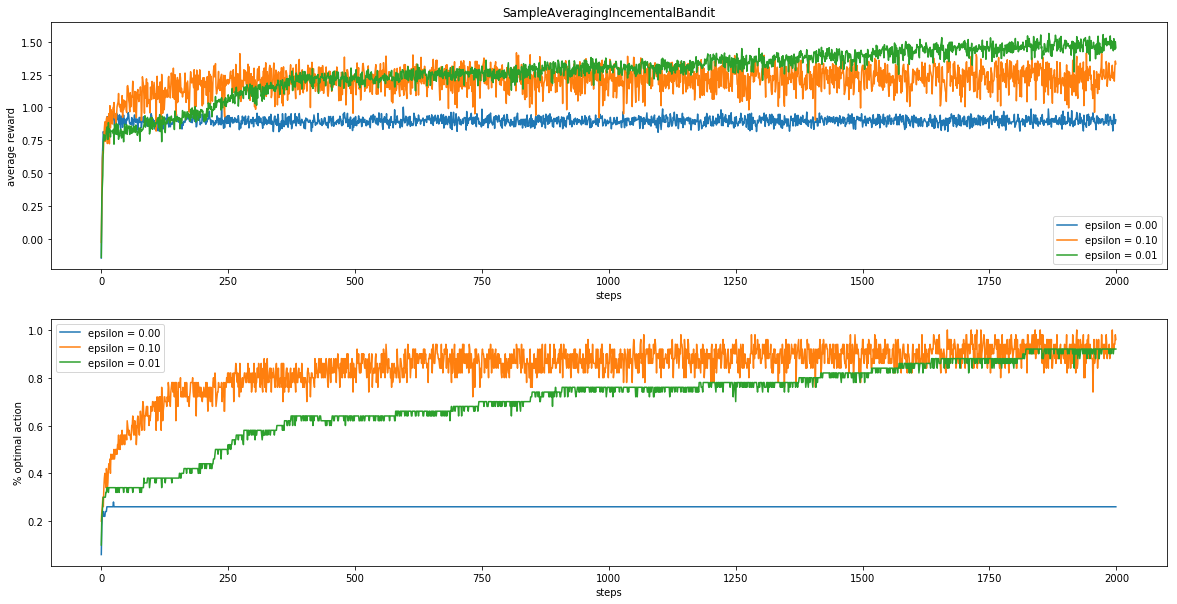

In [8]:
visualize_average_performance(SampleAveragingIncementalBandit)

# Non Stationary

Use a constant step size $\alpha$

$Q(A) \leftarrow Q(A) + \alpha \cdot [R-Q(A)] $

In [9]:
class NonStationaryBandit(Bandit):
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @alpha: step size
    def __init__(self, k_arm=10, epsilon=0.2,alpha=0.1):
        super(NonStationaryBandit,self).__init__(k_arm,epsilon)
        self.alpha = alpha
        
    def __repr__(self):
        return "{}-alpha:{:.3f}".format(super().__repr__(),self.alpha)
        
    def pick_best_action(self):
        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])
    
    def act(self, drift_time=1000):
        if self.time == drift_time:
            self.q_true = np.random.randn(self.k)
            self.best_action = np.argmax(self.q_true)
        return super().act()
        
    def update_estimate(self,action,reward):
        """
        Implement this method using the above equation that uses constant step size
        """
        self.q_estimation[action]  += (reward-self.q_estimation[action]) * self.alpha

100%|██████████| 50/50 [00:02<00:00, 20.47it/s]


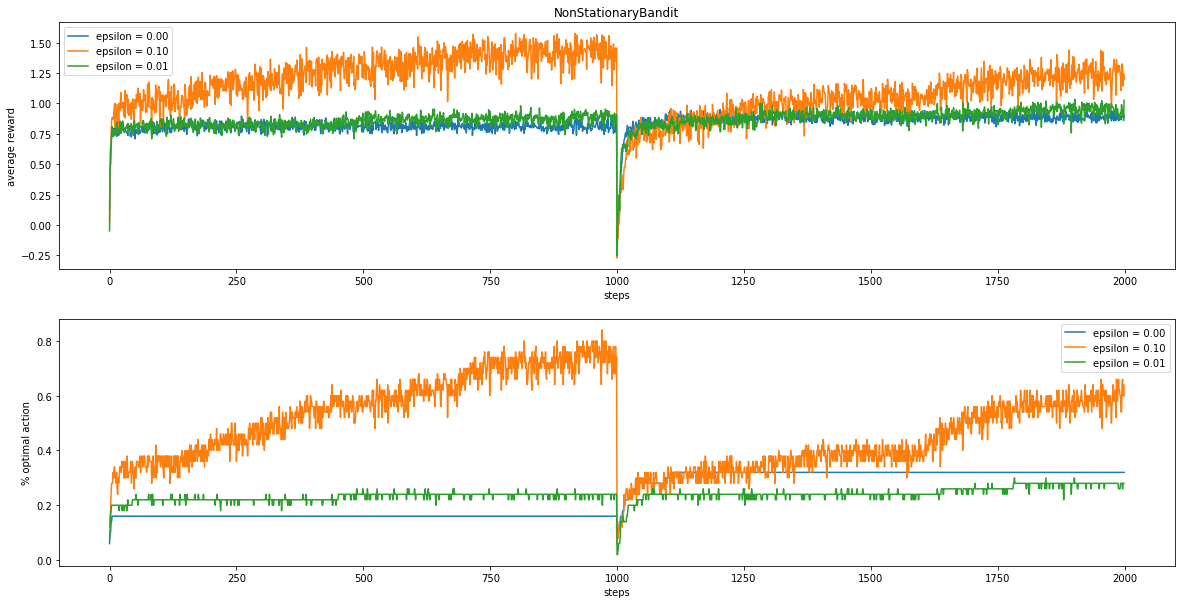

In [10]:
visualize_average_performance(NonStationaryBandit)

# Optimal Initial Values

Initial action values can also be used as a simple way to encourage exploration. Suppose that instead of setting the initial action values to zero, we set them all to 1.

In [11]:
class OptimalInitialValues(SampleAveragingIncementalBandit):
    def reset(self):
        """
        Implement this method
        Set the initial values of q_estimation to 1
        """
        super().reset()
        self.q_estimation += 1

100%|██████████| 50/50 [00:00<00:00, 190.22it/s]


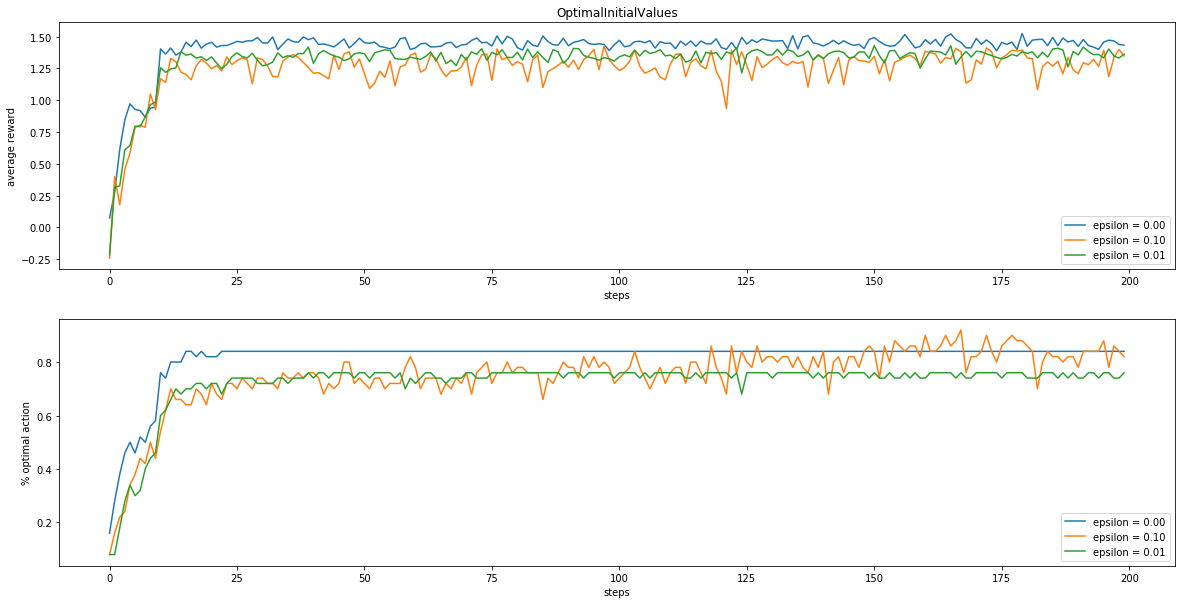

In [12]:
visualize_average_performance(OptimalInitialValues,runs=50,time=200)

# Upper Confidence Bound Action Selection (UCB)

$A_t = \underset{a}{\operatorname{argmax}}\bigg[Q_t(a)+ c\sqrt{\frac{\ln{t}}{N_t(a)}}\bigg]$

Where

$t$ - time step

$N_t(a)$ -  number of times that action $a$ has been selected prior to time $t$ 

The idea of this upper confidence bound (UCB) action selection is that the square-root term is a measure of the uncertainty or variance in the estimate of $a$’s value. The quantity being max’ed over is thus a sort of upper bound on the possible true value of action $a$, with $c$ determining the confidence level. 

In [13]:
class UCBBandit(SampleAveragingIncementalBandit):
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @UCB_confidence: step size
    def __init__(self, k_arm=10, epsilon=0.2,ucb_confidence=0.1):
        super(UCBBandit,self).__init__(k_arm,epsilon)
        self.ucb_confidence = ucb_confidence
        
    def __repr__(self):
        return "{}-ucb_confidence:{:.3f}".format(super().__repr__(),self.ucb_confidence)
    
    def act(self):
        """
        Implement this method
        Select the action based on the above equation
        Avoid divide by zero in by using a very small (1e-5) default value for N(a)
        UCB upper bound for every action gets updated in every timestep
        """
        UCB_estimation = self.q_estimation + self.ucb_confidence * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
        q_best = np.max(UCB_estimation)
        return np.random.choice(np.where(UCB_estimation == q_best)[0])

100%|██████████| 50/50 [00:00<00:00, 302.20it/s]


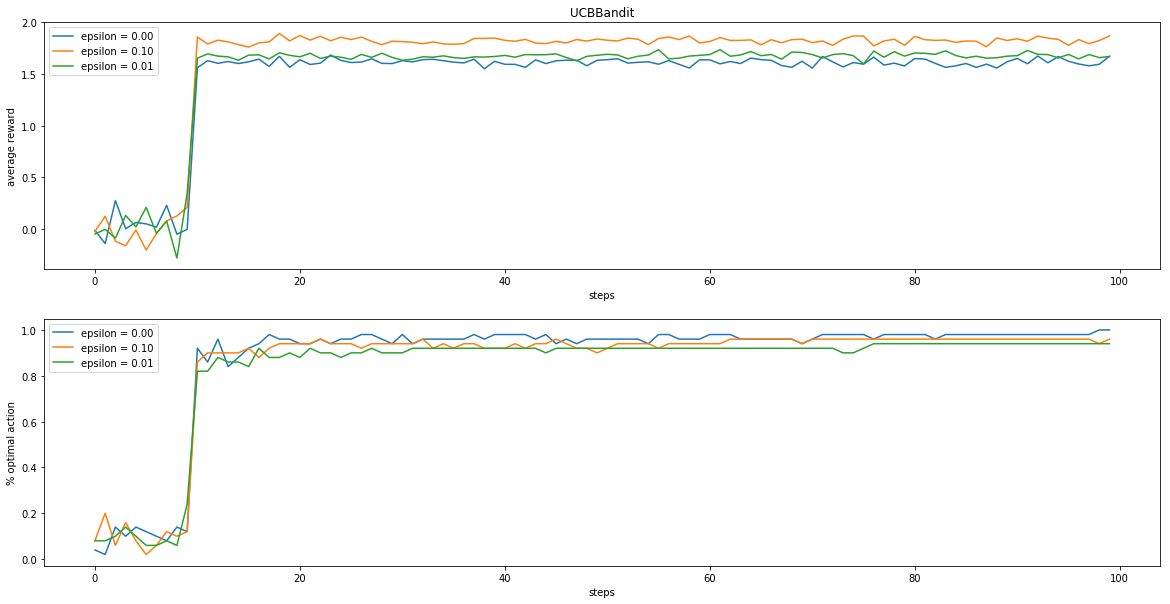

In [14]:
visualize_average_performance(UCBBandit,time=100)

# GradientBandit

The action is to be selected based on the softmax over q_estimation. Here q_estimation is just a numerical preference for an action and does not denote the action value. Hence it is denoted as $H_t(a)$ instead of $Q_t(a)$.

$P(A_t=a) = \frac{e^{H_t(a)}}{\sum_{b=1}^{k}H_t(b)} = \pi_t(a)$ 

The action with the high probability $\pi_t(a)$ is selected.

The numerical preferences are updated as shown below

![grad](./gradient_update.png)

In [15]:
class GradientBandit(SampleAveragingIncementalBandit):
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @alpha: step size
    def __init__(self, k_arm=10, epsilon=0.2,alpha=0.1):
        super(GradientBandit,self).__init__(k_arm,epsilon)
        self.alpha = alpha
    
    def act(self):
        """
        Implement this method
        Select the action based on softmax over q_estimation
        """
        exp_est = np.exp(self.q_estimation)
        self.action_prob = exp_est / np.sum(exp_est)
        return np.random.choice(self.indices, p=self.action_prob)
    
    def update_estimate(self,action,reward):
        """
        Implement this method using the above equation that uses constant step size
        """
        one_hot = np.zeros(self.k)
        one_hot[action] = 1
        self.q_estimation += self.alpha * (reward - self.average_reward) * (one_hot - self.action_prob)

100%|██████████| 50/50 [00:03<00:00, 12.60it/s]


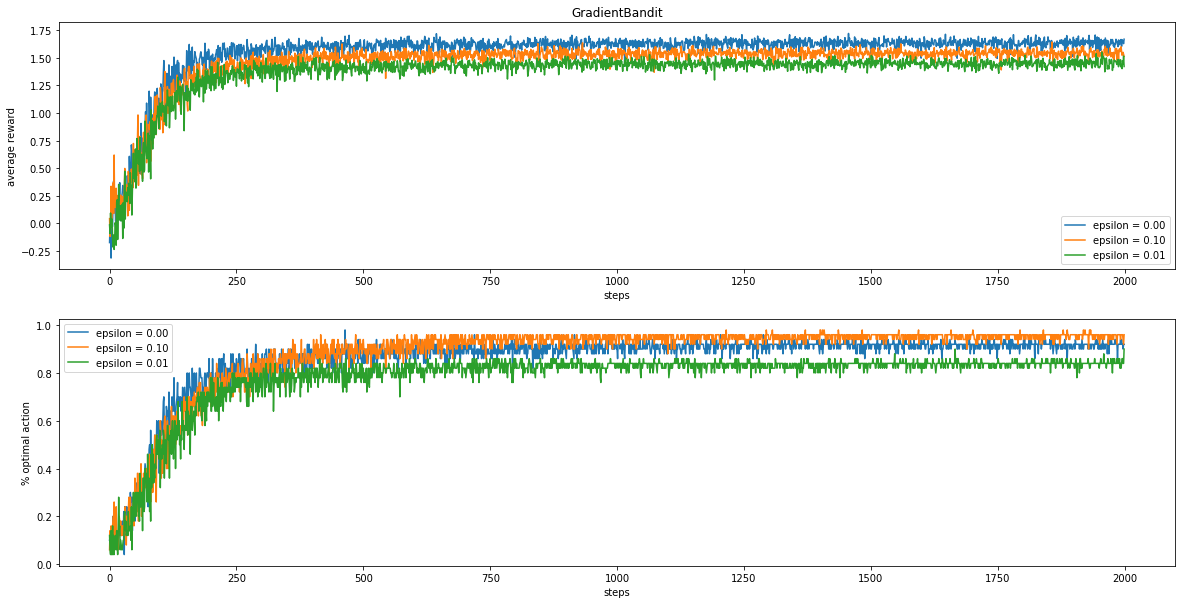

In [16]:
visualize_average_performance(GradientBandit)

In [22]:
bandits = [SampleAveragingBandit(epsilon=0.1),SampleAveragingIncementalBandit(epsilon=0.1),
           OptimalInitialValues(epsilon=0.1),UCBBandit(epsilon=0.1),GradientBandit(epsilon=0.1)]

100%|██████████| 50/50 [00:03<00:00, 12.70it/s]


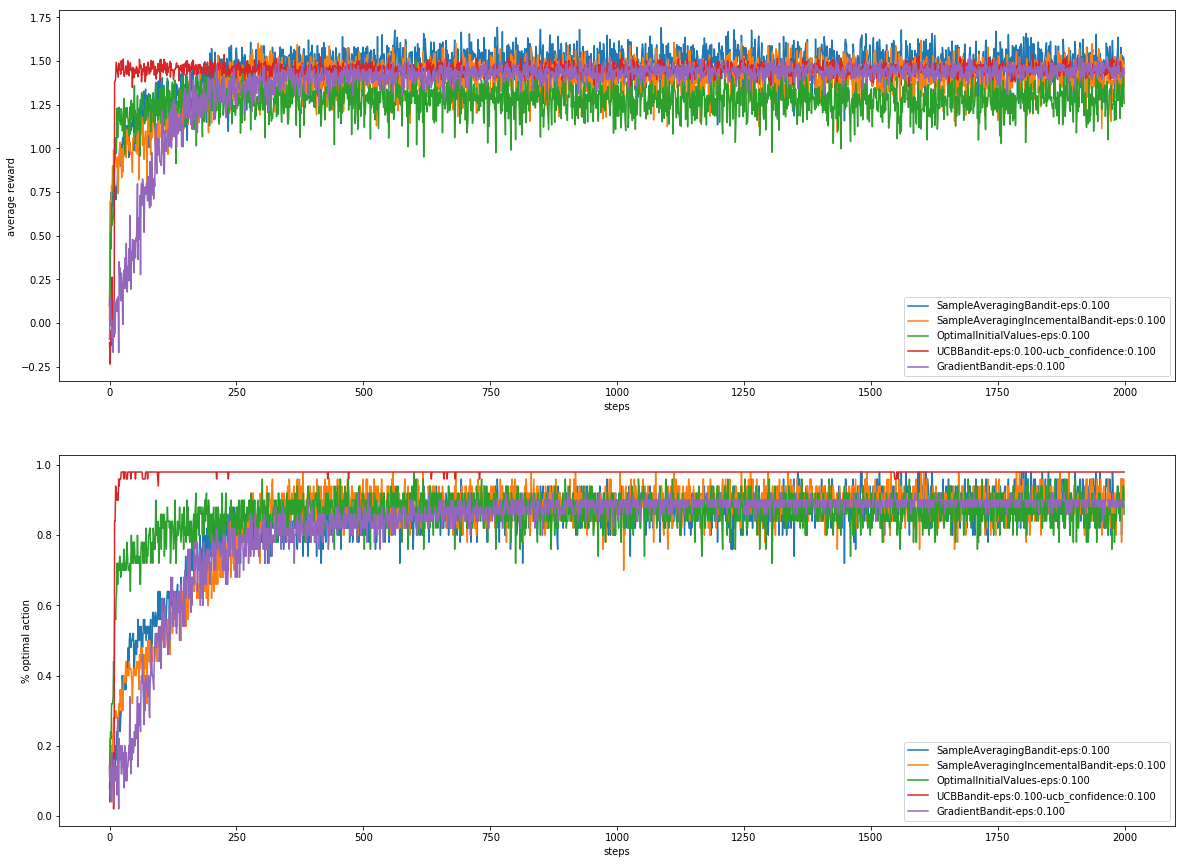

In [23]:
visualize_bandits_avg_performance(bandits)